In [ ]:

import numpy as np
import itertools
import os, fnmatch
import seaborn
import matplotlib.pyplot as plt
from IPython.core.display import HTML, display
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from numpy.random import seed
seed(1)
import librosa.display, librosa

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
path='/content/drive/MyDrive/musical Instrument dataset'
files = []
for root,dirnames,filenames in os.walk(path):
    for filename in fnmatch.filter(filenames,'*.mp3'):
        files.append(os.path.join(root,filename))

print("No.of audio samples:%d"%(len(files)))

No.of audio samples:500


In [ ]:
labels =[]
classes=['bass','clarinet','flute','saxophone','trumpet','banjo','cello','guitar','mandolin','violin']
for filename in files:
    for name in classes:
        if fnmatch.fnmatchcase(filename, '*'+name+'*'):
            labels.append(name)
            break
    else:
        labels.append('other')

In [ ]:
labelencoder = LabelEncoder()
labelencoder.fit(labels)
print(len(labelencoder.classes_), "classes:", ", ".join(list(labelencoder.classes_)))
classes_num = labelencoder.transform(labels)

10 classes: banjo, bass, cello, clarinet, flute, guitar, mandolin, saxophone, trumpet, violin


In [ ]:
fs = 44100
n_fft = 2048
hop_length = 512
n_mels = 128
n_mfcc = 13
testset_size = 0.25
n_neighbors=1

In [ ]:
def get_features(y, sr=fs):
    S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
    mfcc = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=n_mfcc)
    feature_vector = np.mean(mfcc,1)
    return feature_vector


In [ ]:
feature_vectors = []
sound_paths = []
for i,f in enumerate(files):
    print ("get %d of %d = %s"%(i+1, len(files), f))
    try:
        y, sr = librosa.load(f, sr=fs)
        y/=y.max() #Normalize
        if len(y) < 2:
            print("Error loading %s" % f)
            continue
        feat = get_features(y, sr)
        feature_vectors.append(feat)
        sound_paths.append(f)
    except Exception as e:
        print("Error loading %s. Error: %s" % (f,e))

print("Calculated %d feature vectors"%len(feature_vectors))

get 1 of 500 = /content/drive/MyDrive/musical Instrument dataset/banjo_Gs4_very-long_piano_normal.mp3
Error loading /content/drive/MyDrive/musical Instrument dataset/banjo_Gs4_very-long_piano_normal.mp3. Error: melspectrogram() takes 0 positional arguments but 1 positional argument (and 1 keyword-only argument) were given
get 2 of 500 = /content/drive/MyDrive/musical Instrument dataset/trumpet_D5_025_fortissimo_normal.mp3
Error loading /content/drive/MyDrive/musical Instrument dataset/trumpet_D5_025_fortissimo_normal.mp3. Error: melspectrogram() takes 0 positional arguments but 1 positional argument (and 1 keyword-only argument) were given
get 3 of 500 = /content/drive/MyDrive/musical Instrument dataset/banjo_D5_very-long_piano_normal.mp3
Error loading /content/drive/MyDrive/musical Instrument dataset/banjo_D5_very-long_piano_normal.mp3. Error: melspectrogram() takes 0 positional arguments but 1 positional argument (and 1 keyword-only argument) were given
get 4 of 500 = /content/drive/

In [ ]:
scaler = StandardScaler()
scaled_feature_vectors = scaler.fit_transform(np.array(feature_vectors))
print("Feature vectors shape:",scaled_feature_vectors.shape)

ValueError: ignored

In [ ]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=testset_size, random_state=0)
splits = splitter.split(scaled_feature_vectors, classes_num)
for train_index, test_index in splits:
    train_set = scaled_feature_vectors[train_index]
    test_set = scaled_feature_vectors[test_index]
    train_classes = classes_num[train_index]
    test_classes = classes_num[test_index]

NameError: ignored

In [ ]:
print("train_set shape:",train_set.shape)
print("test_set shape:",test_set.shape)
print("train_classes shape:",train_classes.shape)
print("test_classes shape:",test_classes.shape)

train_set shape: (375, 13)
test_set shape: (125, 13)
train_classes shape: (375,)
test_classes shape: (125,)


In [ ]:
n_neighbors=1
model_knn = KNeighborsClassifier(n_neighbors=n_neighbors)

In [ ]:
model_knn.fit(train_set, train_classes);

In [ ]:
predicted_labels = model_knn.predict(test_set)

In [ ]:
print("Recall: ", recall_score(test_classes, predicted_labels,average=None))
print("Precision: ", precision_score(test_classes, predicted_labels,average=None))
print("F1-Score: ", f1_score(test_classes, predicted_labels, average=None))
print("Accuracy: %.2f  ," % accuracy_score(test_classes, predicted_labels,normalize=True), accuracy_score(test_classes, predicted_labels,normalize=False) )
print("Number of samples:",test_classes.shape[0])

Recall:  [0.92307692 0.91666667 0.58333333 0.69230769 1.         0.92307692
 0.61538462 0.92307692 0.83333333 1.        ]
Precision:  [0.70588235 0.84615385 1.         0.81818182 0.8        0.85714286
 1.         0.92307692 1.         0.70588235]
F1-Score:  [0.8        0.88       0.73684211 0.75       0.88888889 0.88888889
 0.76190476 0.92307692 0.90909091 0.82758621]
Accuracy: 0.84  , 105
Number of samples: 125


In [ ]:
cnf_matrix = confusion_matrix(test_classes, predicted_labels)
np.set_printoptions(precision=2)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

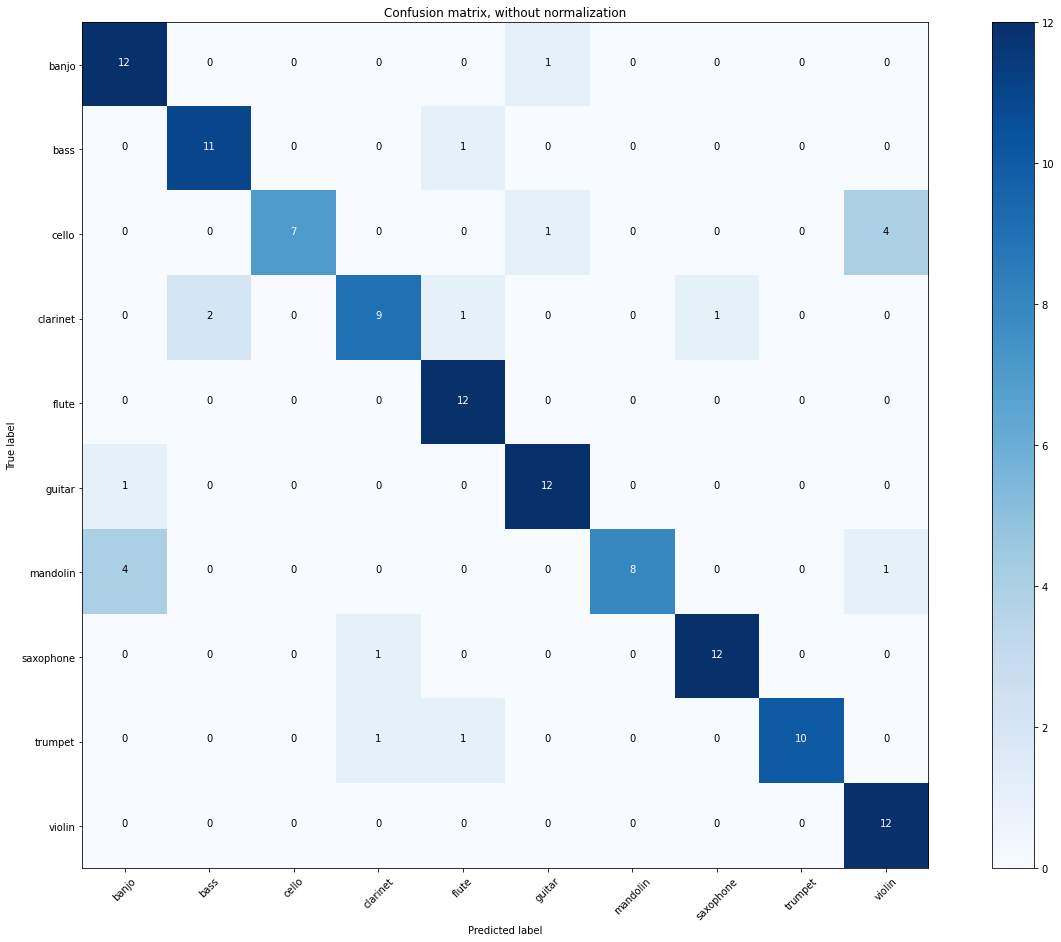

In [ ]:
plt.figure(figsize=(18,13))
plot_confusion_matrix(cnf_matrix, classes=labelencoder.classes_,
                      title='Confusion matrix, without normalization')

In [ ]:
wrong_predictions = [i for i, (e1, e2) in enumerate(zip(predicted_labels,test_classes)) if e1 != e2]

In [ ]:
print(np.array(labels)[test_index[wrong_predictions]])
print(predicted_labels[wrong_predictions].T)
print(labelencoder.inverse_transform(predicted_labels[wrong_predictions]))
#print(np.array(files)[test_index[wrong_predictions]])

['saxophone' 'banjo' 'cello' 'mandolin' 'bass' 'clarinet' 'cello' 'guitar'
 'mandolin' 'cello' 'trumpet' 'clarinet' 'cello' 'trumpet' 'clarinet'
 'mandolin' 'mandolin' 'clarinet' 'mandolin' 'cello']
[3 5 5 0 4 1 9 0 0 9 3 7 9 4 1 0 0 4 9 9]
['clarinet' 'guitar' 'guitar' 'banjo' 'flute' 'bass' 'violin' 'banjo'
 'banjo' 'violin' 'clarinet' 'saxophone' 'violin' 'flute' 'bass' 'banjo'
 'banjo' 'flute' 'violin' 'violin']
